In [1]:
import io
import pathlib
import logging

import dateutil.parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import seaborn

import pyproj
import requests
import rtree


%matplotlib inline


In [2]:
# we do this analysis for the main tide gauges
ids = ['DELFZL', 'DENHDR', 'HARLGN', 'HOEKVHLD', 'IJMDBTHVN', 'VLISSGN']

# datasets
ddl_url = 'https://waterwebservices.rijkswaterstaat.nl/METADATASERVICES_DBO/OphalenCatalogus/'


The NAP history of the 6 main Dutch tide gauges. 
================

The current sea-level rise at the Dutch coast is determined by using 6 main tide gauges, evenly spread across the coast. Each of these stations has a long history of tide gauge records. In this notebook we examine the records that were collected for the levelling of the Dutch Ornance system. 

In [3]:
# Get a list of station info from the DDL
request = {
    "CatalogusFilter": {
        "Eenheden": True,
        "Grootheden": True,
        "Hoedanigheden": True
    }
}
resp = requests.post(ddl_url, json=request)
result = resp.json()

df = pd.DataFrame.from_dict(result['LocatieLijst'])
df = df.set_index('Code')
# note that there are two stations for IJmuiden. 
# The station was moved from the sluices to outside of the harbor in 1981.

# make a copy so we can add things
stations_df = df.loc[ids].copy()


In [4]:
# reproject to other coordinate systems

# We use pyproj
wgs84 = pyproj.Proj(init='epsg:4326')
rd = pyproj.Proj(init='epsg:28992')
etrs89_utm31n = pyproj.Proj(init='epsg:25831')

# compute coordinates in different coordinate systems
stations_df['x_rd'], stations_df['y_rd'] = pyproj.transform(
    etrs89_utm31n, 
    rd, 
    list(stations_df.X), 
    list(stations_df.Y)
)
stations_df['lon'], stations_df['lat'] = pyproj.transform(
    etrs89_utm31n, 
    wgs84, 
    list(stations_df.X), 
    list(stations_df.Y)
)

stations_df

,Coordinatenstelsel,Locatie_MessageID,Naam,X,Y,x_rd,y_rd,lon,lat
Code,,,,,,,,,
DELFZL,25831,84020,Delfzijl,761899.770960,5.915790e+06,258000.000121,594430.000695,6.933123,53.326355
DENHDR,25831,84011,Den Helder,617198.393684,5.869731e+06,111849.999996,553230.000672,4.744990,52.964359
HARLGN,25831,84096,Harlingen,661021.585505,5.894519e+06,156480.000034,576550.000684,5.409342,53.175634
HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06,67929.999957,444000.000612,4.119881,51.977574
IJMDBTHVN,25831,84132,IJmuiden buitenhaven,605633.035699,5.813598e+06,98429.999984,497500.000643,4.554823,52.462326
VLISSGN,25831,84387,Vlissingen,541425.983215,5.699182e+06,30479.999923,385220.000575,3.596057,51.442311


# NAP history

This notebook analyses the history of the Dutch Ordnance Datum (NAP). This is an analysis of the unpublished history of the measurements of the NAP. 
The datasets are derived from different levellings and therefor not unambiguously interpretable. The quality of the measurements can vary and no information about the quality is present. 

The NAP was revised in 2005. The reference level was revised with several centimeters, varying over the Netherlands. The project-ID shows if a measurement was taken before or after the revision. Measurements after 2005 are from the revised level. Some projects have both a revised and unrevised data. Projects with an ‘=’ mark are relative to the revised level. For example: 
Project-ID  370W26 old NAP.
Project-ID  370=26=NAP  same project in revised NAP.


In [5]:
# this is the file that was delivered by Rijkswaterstaat
# The file is a printed table, probably an extract from a database 
path = pathlib.Path('../../../data/rws/nap/historie/NAP_Historie.txt')
# open the file
stream = path.open()
# print the first few lines
print("".join(stream.readlines()[:5]))

+----------+-----------+-----------+----------+------------------------------------------------------------+-------------------------+-----------+
|ID        |x          |y          |project_id|titel                                                       |datum                    |NAP hoogte |
+----------+-----------+-----------+----------+------------------------------------------------------------+-------------------------+-----------+
|000A1011  | 163880.630| 540553.300|279H04    |HYDRO SCHARNEGOUTUM                                         |01-may-1986              |      5.121|
|000A1011  | 163880.630| 540553.300|332=04=NAP|SEC herziening 332w04 groningen friesland 1993              |28-jun-1993              |      5.122|



In [6]:
# because the table is not in a standardized format, we have some cleaning up to do
lines = []
for i, line in enumerate(path.open()):
    # split the first and third line (only dashes and +)
    if i in (0, 2):
        continue
    # strip the | and whitespace
    fields = line.split('|')
    # put all fields in a list and strip of reamining | 
    fields = [field.strip().strip('|') for field in fields]
    # remove first and last column (should be empty)
    assert fields[0] == '' and fields[-1] == ''
    fields = fields[1:-1]
    # rejoin with the | (some fields contain , and ;, so we separate by |)
    line = "|".join(fields)
    # keep a list
    lines.append(line)
# concatenate cleaned up fields
txt = "\n".join(lines)

In [7]:
# read the CSV file as a table
df = pd.read_csv(io.StringIO(txt), sep='|', dtype={
    'titel': str,
    'x': float,
    'y': float
})
# make sure all titles are strings (some floats)
df['titel'] = df['titel'].astype(str)
# convert dates to dates
# did not check if the date format is consistent (not a common date format), let the parser guess
df['date'] = df['datum'].apply(lambda x: dateutil.parser.parse(x))

# based on the instructions, everything with an equal sign or after 2005 should be the revised NAP
# TODO: check if NAP correction is consistent with correction in use by PSMSL to create a local tide gauge benchmark
def is_revised(row):
    if row['date'].year >= 2005:
        return True
    if '=' in row['project_id']:
        return True
    return False
df['revised'] = df.apply(is_revised, axis=1)

The NAP history records show the measurements of the benchmarks in reference to the NAP. Each measurement is done in the context of a project. These projects include the "Waterpassingingen", the countrywide levellings. These are abbreviated as "WP" in this dataset. 

In [8]:
# show the first few records
df.head()

,ID,x,y,project_id,titel,datum,NAP hoogte,date,revised
0,000A1011,163880.63,540553.3,279H04,HYDRO SCHARNEGOUTUM,01-may-1986,5.121,1986-05-01,False
1,000A1011,163880.63,540553.3,332=04=NAP,SEC herziening 332w04 groningen friesland 1993,28-jun-1993,5.122,1993-06-28,True
2,000A1011,163880.63,540553.3,330=01=NAP,SEC herziening 330w01 noord holland 1991,27-feb-1991,5.122,1991-02-27,True
3,000A1011,163880.63,540553.3,332W04,GRONINGEN+FRIESLAND,01-sep-1993,5.121,1993-09-01,False
4,000A1011,163880.63,540553.3,PR3.57,3E NAUWK WP 1950-59,01-jan-1957,5.121,1957-01-01,False


In [9]:
# Some records don't have a location. We can't use them, so we'll drop them out of the dataset
total_n = len(df)
missing_n = total_n - len(df.dropna())
assert missing_n == df['x'].isna().sum(), "we expected all missings to be missings without coordinates"
logging.warning("%s records are dropped from the %s records", missing_n, total_n)
             
df = df.dropna()

NAP measurement locations
==============
We have now read all the data points and cleaned up some unusable records. That leaves us with about 0.5 million measurements.  Here we plot the locations. This gives an idea of the distribution, where more dense areas are shown in darker green. Areas that are measured more often include Groningen, where there is more subsidence, due to gass extraction and Rotterdam.  Notice the triangles and quads that are used to connect the benchmarks. 

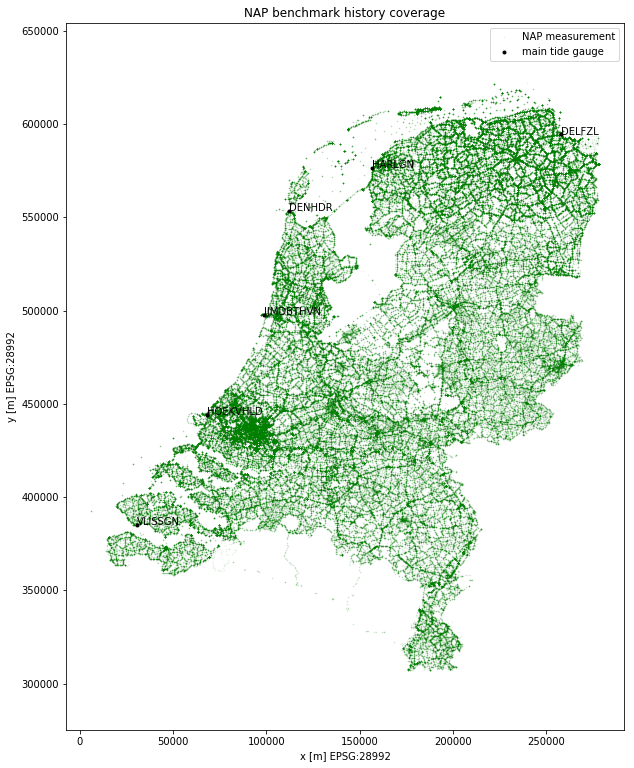

In [10]:

fig, ax = plt.subplots(figsize=(10, 13))
ax.axis('equal')
ax.set_title('NAP benchmark history coverage')
ax.plot(df['x'], df['y'], 'g.', alpha=0.1, markersize=1, label='NAP measurement')
ax.plot(stations_df['x_rd'], stations_df['y_rd'], 'k.', label='main tide gauge')
for name, row in stations_df.iterrows():
    ax.annotate(xy=row[['x_rd', 'y_rd']], s=name)
ax.set_xlabel('x [m] EPSG:28992')
ax.set_ylabel('y [m] EPSG:28992')
ax.legend(loc='best');

Benchmarks close to tide gauges
================= 

Here we'll create an r-tree index to quickly lookup benchmarks near the tide gauges. We'll extract the benchmark locations. Create an index. Use that index to find benchmarks near the tide gauges and then filter by distance. 

For each benchmark we compute a 0 reference. This is the benchmark height when it was first measured. This allows us to focus on the subsidence of each benchmark. 

In [11]:
# create a list of all NAP marks
grouped = df.groupby('ID')
nap_marks = grouped.agg('first')[['x', 'y']]
nap_marks.head()

,x,y
ID,,
000A1011,163880.63,540553.30
000A1012,163906.00,540538.00
000A1013,163890.00,540512.00
000A1014,163864.65,540527.95
000A1015,163882.00,540553.53


In [12]:
# create a rtree to be able to quickly lookup nearest points
index = rtree.Rtree(
    (i, tuple(row) + tuple(row), obj)
    for i, (obj, row)
    in enumerate(nap_marks.iterrows())
)

In [13]:
# here we'll create a list of records that are close to our tide gauges
closest_dfs = []
for station_id in ids:
    # our current station
    station = stations_df.loc[station_id]
    # benchmarks near our current station
    nearest_ids = list(
        item.object
        for item 
        in index.nearest(
            tuple(station[['x_rd', 'y_rd']]), 
            num_results=10000, 
            objects=True
        )
    )
    # lookup corresponding records
    closest = df[np.in1d(df.ID, nearest_ids)].copy()
    # compute the distance
    closest['distance'] = np.sqrt((station['x_rd'] - closest['x'])**2 + (station['y_rd'] - closest['y'])**2)
    # set the station
    closest['station'] = station_id
    # drop all records further than 3km
    # you might want to use a more geological sound approach here, taking into account  faults, etc...
    closest = closest[closest['distance'] <= 3000]
    # sort
    closest = closest.sort_values(by=['station', 'ID', 'date'])
    # loop over each mark to add the 0 reference
    # the 0 reference is the height of the benchmark when it was first measured
    for it, df_group in iter(closest.groupby(('ID', 'x', 'y'))):
        df_group = df_group.copy()
        # add the 0 first height
        hoogtes = df_group['NAP hoogte']
        hoogtes_0 = hoogtes - hoogtes.iloc[0]
        df_group['hoogtes_0'] = hoogtes_0
        closest_dfs.append(df_group)


In [14]:
# combine all the selected records
selected = pd.concat(closest_dfs)
# problem with plotting dates correctly in seaborn, so we'll just use numbers
selected['year'] = selected['date'].apply(lambda x: x.year + x.dayofyear/366.0)


In [15]:
# show the number of measurements for each tide gauge
selected.groupby('station').agg('count')[['ID']]

,ID
station,
DELFZL,1131
DENHDR,396
HARLGN,709
HOEKVHLD,808
IJMDBTHVN,473
VLISSGN,374


Subsidence estimates per station
============

The following figure shows the changes of all the benchmarks that are close to a tide gauges, in a subfigure of the nearby tide gauge. Not all the benchmarks have been measured since the same time and not all benchmarks are measured relative to the same ordnance level. We can compare the trend of all the lines that are plotted. This allows to conclude that all stations are experiencing subsidence. The amount of subsidence is worst in Delfzijl, where the subsidence rate has been at a constant rate of 40cm over the last 70 years. The figures of IJmuiden are inconsistent and the station was moved for unknown reasons. The subsidence rates in other stations are less but still considerable. We estimate the following rates  over the period 1890 - 2017:

- Delfzijl: 0.45m
- Den Helder: 0.18m
- Harlingen: 0.06m
- Hoek van Holland: 0.15cm
- IJmuiden: 0.06cm
- Clissingen: 0.03cm


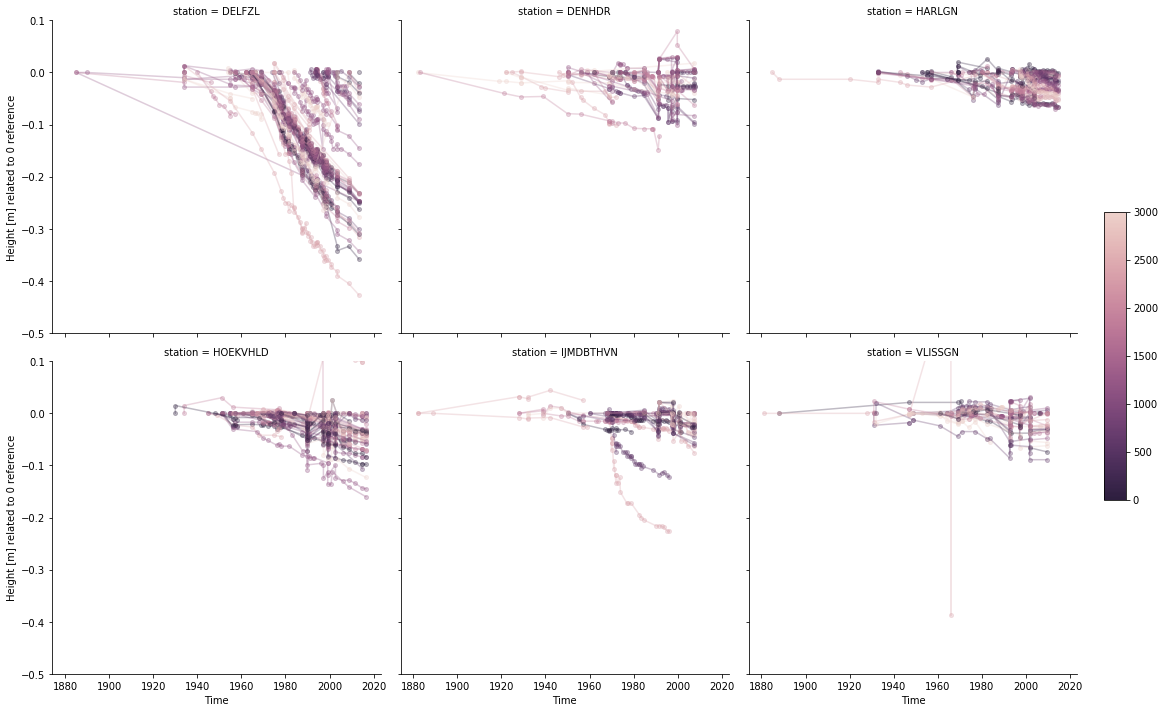

In [16]:
palette = seaborn.palettes.cubehelix_palette(reverse=True)
cmap = seaborn.palettes.cubehelix_palette(reverse=True, as_cmap=True)
grid = seaborn.FacetGrid(selected, col="station", hue="distance", col_wrap=3, palette=palette, size=5)
grid.map(plt.plot, "year", "hoogtes_0", marker="o", ms=4, alpha=0.3)
grid.set(ylim=(-0.5, 0.1))
grid.set_ylabels('Height [m] related to 0 reference')
grid.set_xlabels('Time');
cbar_ax = grid.fig.add_axes([1.01, .3, .02, .4])  # <-- Create a colorbar axes
cb = matplotlib.colorbar.ColorbarBase(
    cbar_ax, 
    cmap=cmap,
    norm=matplotlib.colors.Normalize(0, 3000),
    orientation='vertical'
)